In [1]:
import pandas as pd
import sys
import matplotlib.pyplot as plt

sys.path.append('../src')

from d00_utils.db_utils import dbReadWriteViews, dbReadWriteClean, dbReadWriteRaw

In [2]:
# io_clean = dbReadWriteClean()
# ddff = io_clean.get_table('a_measgraphref')
# ddff.head()

In [3]:
# '2961' in ddff.studyidk

In [4]:
io_views = dbReadWriteViews()

all_df = io_views.get_table('frames_sorted_by_views_temp')

all_df.head()

,instanceidk,indexinmglist,studyidk,frame,is_end_diastolic,is_end_systolic,view,is_multiview
0,57160,0,2882,0.0,False,False,,False
1,57160,1,2882,0.0,False,False,,False
2,57160,2,2882,0.0,False,False,,False
3,57160,3,2882,0.0,False,False,,False
4,57162,0,2882,5.0,False,False,plax,False


In [5]:
all_df.shape

(486877, 8)

In [6]:
# Drop all instances without labels
df5 = all_df.drop(all_df[(all_df['view']=='')].index)
df5['is_multiview'].value_counts()

False    141695
True      35409
Name: is_multiview, dtype: int64

In [7]:
df5.head()

,instanceidk,indexinmglist,studyidk,frame,is_end_diastolic,is_end_systolic,view,is_multiview
4,57162,0,2882,5.0,False,False,plax,False
5,57164,0,2882,8.0,False,True,a4c,False
6,57164,1,2882,15.0,True,False,a4c,False
11,57571,0,2915,0.0,True,False,plax,False
12,57571,1,2915,0.0,False,True,plax,False


In [8]:
# Get db which contains all off-limits instances for other classes
# e.g. is 'is_multiview'==True
conflict_inst_df = df5.drop(df5[(df5['is_multiview']==False)].index)
agg_functions_conflict = {'studyidk': 'first'}
conflict_inst_df = conflict_inst_df.groupby(['instanceidk']).agg(agg_functions_conflict)
conflict_inst_df.reset_index(inplace=True)
conflict_inst_df.head()

,instanceidk,studyidk
0,58207,2966
1,110441,6363
2,117616,6852
3,119931,6996
4,124996,7331


In [9]:
#io_views.save_to_db(conflict_inst_df, 'instances_with_conflicts')

In [10]:
all_df = df5

In [11]:
# Remove instances with view conflicts
conflict_sets = all_df[all_df['is_multiview']==True].groupby('instanceidk')#.agg({'view': lambda x: set(x)})

conflict_list = []
for instance in list(conflict_sets.instanceidk):
    conflict_list.append(instance[0]) # get instanceidk for multidimn list
    
frames_without_conflicts_df = all_df[~all_df['instanceidk'].isin(conflict_list)]
frames_without_conflicts_df.shape

(141695, 8)

In [12]:
# Check to make sure no view conflicts exist
frames_without_conflicts_df['is_multiview'].value_counts()

False    141695
Name: is_multiview, dtype: int64

In [13]:
# Drop unnecessary column
frames_without_conflicts_df.drop('is_multiview', axis=1, inplace=True)
frames_without_conflicts_df.head()

/home/dave_van_veen/anaconda3/envs/dssg/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,instanceidk,indexinmglist,studyidk,frame,is_end_diastolic,is_end_systolic,view
4,57162,0,2882,5.0,False,False,plax
5,57164,0,2882,8.0,False,True,a4c
6,57164,1,2882,15.0,True,False,a4c
11,57571,0,2915,0.0,True,False,plax
12,57571,1,2915,0.0,False,True,plax


In [14]:
# Drop all instances without labels
# df2 = frames_without_conflicts_df
# labels_by_frame_df = df2.drop(df2[(df2['view']=='')].index)

labels_by_frame_df = frames_without_conflicts_df
labels_by_frame_df.head()

,instanceidk,indexinmglist,studyidk,frame,is_end_diastolic,is_end_systolic,view
4,57162,0,2882,5.0,False,False,plax
5,57164,0,2882,8.0,False,True,a4c
6,57164,1,2882,15.0,True,False,a4c
11,57571,0,2915,0.0,True,False,plax
12,57571,1,2915,0.0,False,True,plax


In [15]:
#io_views.save_to_db(labels_by_frame_df, 'frames_with_labels')

(array([1.5617e+04, 1.2755e+04, 1.1700e+04, 7.8090e+03, 3.2840e+03,
        1.9880e+03, 6.9900e+02, 7.2000e+01, 1.6000e+01, 1.3000e+01,
        7.0000e+00, 1.0000e+00, 4.0000e+00]),
 array([ 1.        ,  1.92307692,  2.84615385,  3.76923077,  4.69230769,
         5.61538462,  6.53846154,  7.46153846,  8.38461538,  9.30769231,
        10.23076923, 11.15384615, 12.07692308, 13.        ]),
 <a list of 13 Patch objects>)

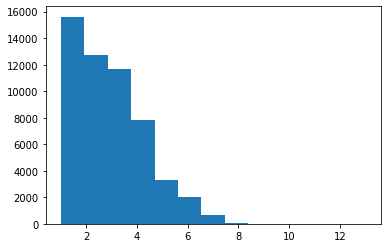

In [16]:
# Histogram showing number of labeled frames from each instance
plt.hist(labels_by_frame_df['instanceidk'].value_counts().values, bins=13)

In [17]:
# Group all frames of same instance, drop frame-specific columns
agg_functions = {'view': 'first', 'studyidk': 'first'}
labels_by_inst_df = labels_by_frame_df.groupby(['instanceidk']).agg(agg_functions)
# labels_by_instance

labels_by_inst_df = labels_by_inst_df.reset_index()
labels_by_inst_df.head()

,instanceidk,view,studyidk
0,57162,plax,2882
1,57164,a4c,2882
2,57571,plax,2915
3,58204,plax,2966
4,58713,plax,3009


In [18]:
labels_by_inst_df.shape

(53965, 3)

In [19]:
#io_views.save_to_db(labels_by_inst_df, 'instances_with_labels')

In [20]:
#902k, interpolated 952k

In [51]:
io_clean = dbReadWriteClean()

filename_list_df = io_clean.get_table('instance_filename')
filename_list_df.drop(labels=['row_id', 'seriesdbkey'], axis=1, inplace=True)
filename_list_df.head()

,instanceidk,instancefilename,sopinstanceuid
0,57157,6RYXZNZW,1.2.840.113543.6.6.4.6.62554526370968849932129...
1,57158,6RYXZO03,1.2.840.113543.6.6.4.6.64175920513291079284612...
2,57159,6RYXZO0D,1.2.840.113543.6.6.4.6.63515355813678132433121...
3,57160,6RYXZO0K,1.2.840.113543.6.6.4.6.63385835434171778347132...
4,57161,6RYXZO0Y,1.2.840.113543.6.6.4.6.62250778798156715321013...


In [52]:
filename_list_df.shape

(902577, 3)

In [53]:
# Drop all rows which have duplicate values in the following columns
cols_drop_duplicates = ['sopinstanceuid', 'instanceidk', 'instancefilename']
for col in cols_drop_duplicates:
    filename_list_df.drop_duplicates(subset=col, keep=False, inplace=True)

filename_list_df.shape

(895206, 3)

In [54]:
# print(len(filename_list_df['sopinstanceuid'].unique().tolist()))

In [55]:
io_raw  = dbReadWriteRaw()

A_instance_df = io_raw.get_table('a_instance')
A_instance_df['instanceidk'] = A_instance_df['instanceidk'].astype('int')
# Drop unnecessary columns
A_instance_df.drop(labels=['row_id', 'sopclassuid'], axis=1, inplace=True)

A_instance_df.head()

,instanceidk,studyseriesidk,sopinstanceuid
0,57157,2912.0,1.2.840.113543.6.6.4.6.62554526370968849932129...
1,57158,2912.0,1.2.840.113543.6.6.4.6.64175920513291079284612...
2,57159,2912.0,1.2.840.113543.6.6.4.6.63515355813678132433121...
3,57160,2912.0,1.2.840.113543.6.6.4.6.63385835434171778347132...
4,57161,2912.0,1.2.840.113543.6.6.4.6.62250778798156715321013...


In [56]:
A_instance_df.shape

(904178, 3)

In [57]:
print(len(A_instance_df['sopinstanceuid'].unique().tolist()))
print(len(A_instance_df['instanceidk'].unique().tolist()))

# Drop all rows which have duplicate values in the following columns
cols_drop_duplicates = ['sopinstanceuid', 'instanceidk']
for col in cols_drop_duplicates:
    A_instance_df.drop_duplicates(subset=col, keep=False, inplace=True)

A_instance_df.shape

898424
904178


(895272, 3)

In [70]:
A_study_series_df = io_raw.get_table('a_studyseries')
A_study_series_df.drop(labels=['row_id', 'studyseriesuid', 'modality'], axis=1, inplace=True)
A_study_series_df.head()

,studyseriesidk,studyinstanceidk
0,2912.0,2882.0
1,2961.0,2915.0
2,3010.0,2965.0
3,3011.0,2966.0
4,3054.0,3009.0


In [71]:
print(A_study_series_df.shape)
print(len(A_study_series_df['studyseriesidk'].unique().tolist()))

(37195, 2)
37195


In [72]:
merge_df = A_instance_df.merge(filename_list_df, on='sopinstanceuid')
merge_df.head()

,instanceidk_x,studyseriesidk,sopinstanceuid,instanceidk_y,instancefilename
0,57157,2912.0,1.2.840.113543.6.6.4.6.62554526370968849932129...,57157,6RYXZNZW
1,57158,2912.0,1.2.840.113543.6.6.4.6.64175920513291079284612...,57158,6RYXZO03
2,57159,2912.0,1.2.840.113543.6.6.4.6.63515355813678132433121...,57159,6RYXZO0D
3,57160,2912.0,1.2.840.113543.6.6.4.6.63385835434171778347132...,57160,6RYXZO0K
4,57161,2912.0,1.2.840.113543.6.6.4.6.62250778798156715321013...,57161,6RYXZO0Y


In [73]:
merge_df = merge_df[merge_df['instanceidk_x'] == merge_df['instanceidk_y']]
merge_df['instanceidk'] = merge_df['instanceidk_x']

In [74]:
cols_to_drop = ['instanceidk_x', 'instanceidk_y']
merge_df.drop(labels=cols_to_drop, axis=1, inplace=True)

merge_df.head()

,studyseriesidk,sopinstanceuid,instancefilename,instanceidk
0,2912.0,1.2.840.113543.6.6.4.6.62554526370968849932129...,6RYXZNZW,57157
1,2912.0,1.2.840.113543.6.6.4.6.64175920513291079284612...,6RYXZO03,57158
2,2912.0,1.2.840.113543.6.6.4.6.63515355813678132433121...,6RYXZO0D,57159
3,2912.0,1.2.840.113543.6.6.4.6.63385835434171778347132...,6RYXZO0K,57160
4,2912.0,1.2.840.113543.6.6.4.6.62250778798156715321013...,6RYXZO0Y,57161


In [75]:
print(merge_df.shape)
print(len(merge_df['sopinstanceuid'].unique().tolist()))
print(len(merge_df['instanceidk'].unique().tolist()))
print(len(merge_df['instancefilename'].unique().tolist()))
print(len(merge_df['studyseriesidk'].unique().tolist()))

(895167, 4)
895167
895167
895167
34665


In [76]:
merge2_df = merge_df.merge(A_study_series_df, on = 'studyseriesidk')

merge2_df.head()

,studyseriesidk,sopinstanceuid,instancefilename,instanceidk,studyinstanceidk
0,2912.0,1.2.840.113543.6.6.4.6.62554526370968849932129...,6RYXZNZW,57157,2882.0
1,2912.0,1.2.840.113543.6.6.4.6.64175920513291079284612...,6RYXZO03,57158,2882.0
2,2912.0,1.2.840.113543.6.6.4.6.63515355813678132433121...,6RYXZO0D,57159,2882.0
3,2912.0,1.2.840.113543.6.6.4.6.63385835434171778347132...,6RYXZO0K,57160,2882.0
4,2912.0,1.2.840.113543.6.6.4.6.62250778798156715321013...,6RYXZO0Y,57161,2882.0


In [69]:
print(merge2_df.shape)
print(len(merge2_df['studyseriesidk'].unique().tolist()))

(895167, 7)
34665


In [77]:
merge2_df.drop(labels='studyseriesidk', axis=1, inplace=True)

In [80]:
merge2_df['studyinstanceidk'] = merge2_df['studyinstanceidk'].astype('int')
merge2_df.head()

,sopinstanceuid,instancefilename,instanceidk,studyinstanceidk
0,1.2.840.113543.6.6.4.6.62554526370968849932129...,6RYXZNZW,57157,2882
1,1.2.840.113543.6.6.4.6.64175920513291079284612...,6RYXZO03,57158,2882
2,1.2.840.113543.6.6.4.6.63515355813678132433121...,6RYXZO0D,57159,2882
3,1.2.840.113543.6.6.4.6.63385835434171778347132...,6RYXZO0K,57160,2882
4,1.2.840.113543.6.6.4.6.62250778798156715321013...,6RYXZO0Y,57161,2882


In [78]:
print(len(merge2_df['sopinstanceuid'].unique().tolist()))
print(len(merge2_df['instanceidk'].unique().tolist()))
print(len(merge2_df['instancefilename'].unique().tolist()))
print(len(merge2_df['studyinstanceidk'].unique().tolist()))

895167
895167
895167
24997


In [79]:
io_views.save_to_db(merge2_df, 'instances_unique_master_list')

(array([8.95246e+05, 1.52700e+03, 1.27300e+03, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 3.90000e+01, 6.00000e+00, 1.10000e+01, 1.00000e+00,
        1.00000e+00, 1.00000e+00]),
 array([ 1.        ,  1.91666667,  2.83333333,  3.75      ,  4.66666667,
         5.58333333,  6.5       ,  7.41666667,  8.33333333,  9.25      ,
        10.16666667, 11.08333333, 12.        ]),
 <a list of 12 Patch objects>)

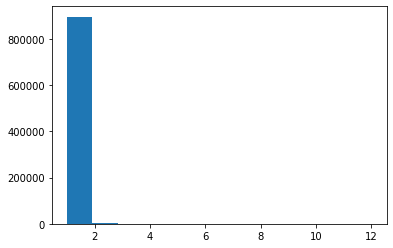

In [26]:
# filename_list_df['sopinstanceuid'].value_counts()

plt.hist(filename_list_df['instanceidk'].value_counts().values, bins=12)

In [27]:
filename_list_df.shape

(902577, 5)

In [ ]:
# wnat to get list of studyidk, instanceidk

In [43]:
import s3fs
import os
from json import load

# aws s3 credentials, path
with open('credentials_dave.json') as f:
    credentials = load(f)
s3 = s3fs.S3FileSystem(key=credentials['dssg']['aws_access_key_id'], secret=credentials['dssg']['aws_secret_access_key'])

s3_path = 's3://cibercv/' # to which bucket
s3_study_paths = s3.ls(s3_path)[1:-1] # list the content of a bucket

In [50]:
len(s3_study_paths)
study_paths = s3_study_paths[2:-2] #get rid of non-study paths in directory

In [51]:
for study in study_paths[0:5]:
    file_list = s3.ls('s3://' + study)
    print(file_list)

['cibercv/100000/a_6MI50JZH.dcm', 'cibercv/100000/a_6MI50JZR.dcm', 'cibercv/100000/a_6MI50K04.dcm', 'cibercv/100000/a_6MI50K0H.dcm', 'cibercv/100000/a_6MI50K10.dcm', 'cibercv/100000/a_6MI50K1D.dcm', 'cibercv/100000/a_6MI50K1K.dcm', 'cibercv/100000/a_6MI50K1M.dcm', 'cibercv/100000/a_6MI50K1W.dcm', 'cibercv/100000/a_6MI50K27.dcm', 'cibercv/100000/a_6MI50K2H.dcm', 'cibercv/100000/a_6MI50K2N.dcm', 'cibercv/100000/a_6MI50K2Y.dcm', 'cibercv/100000/a_6MI50K39.dcm', 'cibercv/100000/a_6MI50K3C.dcm', 'cibercv/100000/a_6MI50K3M.dcm', 'cibercv/100000/a_6MI50K3X.dcm', 'cibercv/100000/a_6MI50K47.dcm', 'cibercv/100000/a_6MI50K4E.dcm', 'cibercv/100000/a_6MI50K4H.dcm', 'cibercv/100000/a_6MI50K4J.dcm', 'cibercv/100000/a_6MI50K4M.dcm', 'cibercv/100000/a_6MI50K4O.dcm', 'cibercv/100000/a_6MI50K4R.dcm', 'cibercv/100000/a_6MI50K4T.dcm', 'cibercv/100000/a_6MI50K4V.dcm', 'cibercv/100000/a_6MI50K4X.dcm', 'cibercv/100000/a_6MI50K57.dcm', 'cibercv/100000/a_6MI50K5G.dcm', 'cibercv/100000/a_6MI50K5P.dcm']
['cibercv

In [37]:
# cond = (filename_list_df['instanceidk'].value_counts() > 1)
single = filename_list_df.drop_duplicates(subset='instanceidk')
# inst_mult = filename_list_df[cond==True].index
single['instanceidk'].value_counts().max()
# ddf1 = filename_list_df.groupby(['instanceidk'])

1

In [39]:
single.head()

,row_id,instanceidk,instancefilename,sopinstanceuid,seriesdbkey
0,1,57157,6RYXZNZW,1.2.840.113543.6.6.4.6.62554526370968849932129...,2912
1,2,57158,6RYXZO03,1.2.840.113543.6.6.4.6.64175920513291079284612...,2912
2,3,57159,6RYXZO0D,1.2.840.113543.6.6.4.6.63515355813678132433121...,2912
3,4,57160,6RYXZO0K,1.2.840.113543.6.6.4.6.63385835434171778347132...,2912
4,5,57161,6RYXZO0Y,1.2.840.113543.6.6.4.6.62250778798156715321013...,2912
